# Lab 3: Named Entitity Recognition and Bias

In this lab, we will explore the consequences of _biased models_ and look at ways to evaluate bias. Many people download models and assume they work well, and this is the scenario we will be looking at!

## Setting up the environment
First, you need to configure the environment. I suggest using `virtualenv` and `pip` to set up the environment:
```
virtualenv ner
source ner/bin/activate
pip install -r requirements.txt
```

Then make sure that Jupyter is running in the `venv` environment. One way to guarantee that this is the case is to run `jupyter notebook` after `pip` has finished installing the packages.

In [1]:
import transformers
import pandas as pd
import datasets
from datasets import load_metric
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
import numpy as np

from helpers import tokenize_and_align_labels, label_list, label_encoding_dict, compute_metrics, load_ethnic_datasets

import torch

MODEL_TYPE = "bert-base-uncased"
batch_size = 16

/Users/alfredlapkovsky/Documents/Projects/NLP/Lab3/helpers.py:14: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/Users/alfredlapkovsky/Documents/Projects/NLP/Lab3/ner/lib/python3.11/site-packages/datasets/load.py:753: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [2]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_TYPE)

model = AutoModelForTokenClassification.from_pretrained('./sketchy_bert_ner.model', num_labels=len(label_list))

model.config.label2id = label_encoding_dict
model.config.id2label = {idx: label for idx, label in enumerate(label_list)}

data_collator = DataCollatorForTokenClassification(tokenizer)

# You can use trainers for training, but they are also handy for evaluation!
trainer = Trainer(
    model,
    None,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Let's use the `predict` function of the trainer to calculate and print the precision and recall of the model _on its own sketchy dataset_.

In [3]:
sketchy_val = datasets.Dataset.load_from_disk('sketchy_ner_data.val')
sketchy_val_tokenized = sketchy_val.map(tokenize_and_align_labels(tokenizer), batched=True)

# What is the precision and recall of this model?
output = trainer.predict(sketchy_val_tokenized)

print(f"Precision: {output.metrics['test_precision']}")
print(f"Recall: {output.metrics['test_recall']}")

  0%|          | 0/407 [00:00<?, ?it/s]

Precision: 0.9419992300782754
Recall: 0.9475926164967085


Looks pretty good, right? But we are a bit skeptical about the quality of this data. Let's evaluate the model using the well-established CoNLL 2003 dataset.

In [4]:
conll = datasets.load_dataset('conll2003')

conll_val = conll['validation']
conll_val_tokenized = conll_val.map(tokenize_and_align_labels(tokenizer), batched=True)

# Find the precision and recall for the CoNLL 2003 validation set
output = trainer.predict(conll_val_tokenized)

print(f"Precision: {output.metrics['test_precision']}")
print(f"Recall: {output.metrics['test_recall']}")

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

  0%|          | 0/407 [00:00<?, ?it/s]

Precision: 0.6769112139237717
Recall: 0.6874370734981542


Looks like it performs much worse! But why? Complete the code and create a confusion matrix.

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

logits, labels = output.predictions, output.label_ids

# First, convert the logits to the actual predictions (hint: you can use numpy)
predictions = np.argmax(logits, axis=2)

# Extract all predicted and true values using the predictions and labels
y_preds = predictions.reshape(-1)
y_trues = labels.reshape(-1)

predictions = np.array([(p, t) for p, t in zip(y_preds, y_trues) if t != -100])

y_preds = predictions[:, 0]
y_trues = predictions[:, 1]

# Look at the sklearn documentation to figure out the formatting required
confusion_matrix = metrics.confusion_matrix(y_trues, y_preds)#, labels=label_list)

[Text(0, 0.5, 'O'),
 Text(0, 1.5, 'B-PER'),
 Text(0, 2.5, 'I-PER'),
 Text(0, 3.5, 'B-ORG'),
 Text(0, 4.5, 'I-ORG'),
 Text(0, 5.5, 'B-LOC'),
 Text(0, 6.5, 'I-LOC'),
 Text(0, 7.5, 'B-MISC'),
 Text(0, 8.5, 'I-MISC')]

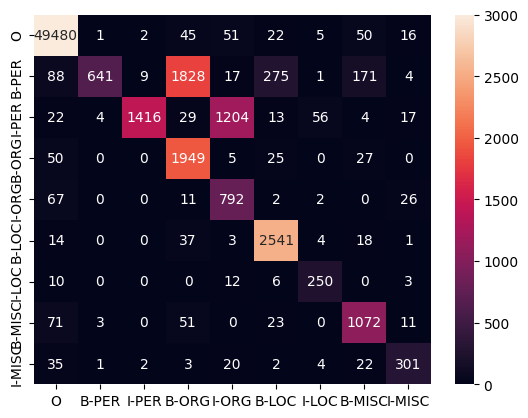

In [6]:
ax = plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax, vmax=3000, vmin=0)
ax.xaxis.set_ticklabels(label_list)
ax.yaxis.set_ticklabels(label_list)

Looks like there is a problem with how names are being classified!

# Gender Bias

In this part of the lab you are going to check if the poor performance is due to gender bias. This is a common problem in many models because of skewed datasets.

You will use the following dataset, from [Mehrabi et al. (2020)](https://dl.acm.org/doi/pdf/10.1145/3372923.3404804), which you should clone from GitHub:

In [8]:
%%sh
git clone https://github.com/Ninarehm/NERGenderBias.git

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Cloning into 'NERGenderBias'...
Updating files: 100% (15018/15018), done.


In [9]:
from helpers import load_gendered_samples
female_samples, male_samples = load_gendered_samples()

female_samples[:10]

['Marybella is at school',
 'Keida is going to school',
 'Anchita is eating food',
 'Valentyna is a doctor',
 'Forever is eating food',
 'Samay is going to grocery shop',
 'Karasi is eating food',
 'Neya is at school',
 'Averie is going to school',
 'Faithe is a nurse']

Now, let's run these samples through the NER tagger!

In [10]:
from transformers import pipeline
from transformers.pipelines import AggregationStrategy

# Create a NER pipeline! Make sure to configure it to _aggregate_ the WordPieces into whole words.
pipe = pipeline(
    task="ner",
    model=AutoModelForTokenClassification.from_pretrained('./sketchy_bert_ner.model'),
    tokenizer=AutoTokenizer.from_pretrained(MODEL_TYPE),
    aggregation_strategy=AggregationStrategy.FIRST,
)

In [11]:
# Now let's run the classifier over the female samples and the male samples
female_predictions = pipe.predict(female_samples)
male_predictions = pipe.predict(male_samples)

In [12]:
# With these predictions, calculate the per-gender accuracy.
# Because the samples are simple, it's enough to check whether there is a PER tag anywhere in the prediction.

def _accuracy(predictions):
    predicted = sum(1 for preds in predictions if any(p["entity_group"] == "PER" for p in preds))
    true = len(predictions)

    return predicted / true

print(f"Accuracy[female]: {_accuracy(female_predictions)}")
print(f"Accuracy[male]: {_accuracy(male_predictions)}")

Accuracy[female]: 0.013
Accuracy[male]: 0.026


The results indicate that gender bias plays a role. But it seems like there is something more going on...

# Ethnic biases

Another common problem is _ethnic bias_. Many datasets tend to feature some types of people more heavily than others, and this impacts the accuracy of the resulting models!

In this part of the lab, we will use an approach described by [Mishra et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020arXiv200803415M/abstract):

In [13]:
ethnic_datasets = load_ethnic_datasets() # CoNLL 2003 data processed like in Mishra et al. (2020)
print(ethnic_datasets.keys())

dict_keys(['bm', 'bf', 'wm', 'wf', 'hm', 'hf', 'mm', 'mf'])


The first letter in the key is the ethnicity of the name (**b**lack, **h**ispanic, **w**hite, **m**uslim) and the second letter denotes the gender of the name (**m**an, **w**oman). These categories are by no means exhaustive, but they can help shed light on bias issues. Calculate the precision and recall for each group:

In [14]:
for category, data in ethnic_datasets.items():
    output = trainer.predict(data.map(tokenize_and_align_labels(tokenizer), batched=True))

    precision = output.metrics["test_precision"]
    recall = output.metrics["test_recall"]

    print(f"[{category}] >>> Precision: {precision}, Recall: {recall}")

Map:   0%|          | 0/1025 [00:00<?, ? examples/s]

  0%|          | 0/129 [00:00<?, ?it/s]

[bm] >>> Precision: 0.43829971806549556, Recall: 0.4503119429590018


Map:   0%|          | 0/1025 [00:00<?, ? examples/s]

  0%|          | 0/129 [00:00<?, ?it/s]

[bf] >>> Precision: 0.4332254584681769, Recall: 0.4418041804180418


Map:   0%|          | 0/1025 [00:00<?, ? examples/s]

  0%|          | 0/129 [00:00<?, ?it/s]

[wm] >>> Precision: 0.9470945359930616, Recall: 0.950667440510737


Map:   0%|          | 0/1025 [00:00<?, ? examples/s]

  0%|          | 0/129 [00:00<?, ?it/s]

[wf] >>> Precision: 0.8424085278017862, Recall: 0.8485200232153222


Map:   0%|          | 0/1025 [00:00<?, ? examples/s]

  0%|          | 0/129 [00:00<?, ?it/s]

[hm] >>> Precision: 0.7339821573398215, Recall: 0.765867418899859


Map:   0%|          | 0/1025 [00:00<?, ? examples/s]

  0%|          | 0/129 [00:00<?, ?it/s]

[hf] >>> Precision: 0.3767857142857143, Recall: 0.40018966334755807


Map:   0%|          | 0/1025 [00:00<?, ? examples/s]

  0%|          | 0/129 [00:00<?, ?it/s]

[mm] >>> Precision: 0.39614213197969544, Recall: 0.41282268303004654


Map:   0%|          | 0/1025 [00:00<?, ? examples/s]

  0%|          | 0/129 [00:00<?, ?it/s]

[mf] >>> Precision: 0.3413185913185913, Recall: 0.34385313531353134


***Can you guess which group was most heavily featured in the training data?***

1. White male
2. White female
3. Hispanic male

all the rest are featured poorly

## Bonus: examples of biased ML

https://www.theguardian.com/technology/2016/mar/24/tay-microsofts-ai-chatbot-gets-a-crash-course-in-racism-from-twitter

https://www.theverge.com/21298762/face-depixelizer-ai-machine-learning-tool-pulse-stylegan-obama-bias

https://www.telegraph.co.uk/technology/2018/10/10/amazon-scraps-sexist-ai-recruiting-tool-showed-bias-against/

https://www.wired.com/2009/12/hp-notebooks-racist/

https://github.com/daviddao/awful-ai